In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

In [ ]:
# Creating parameters

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

# New Section

In [ ]:
# Creating test/train split

splitRatio = 0.8
trainSplit = int(splitRatio * len(X))

XTrain, yTrain = X[:trainSplit], y[:trainSplit]
XTest, yTest = X[trainSplit:], y[trainSplit:]

len(XTrain), len(yTrain), len(XTest), len(yTest)

(40, 40, 10, 10)

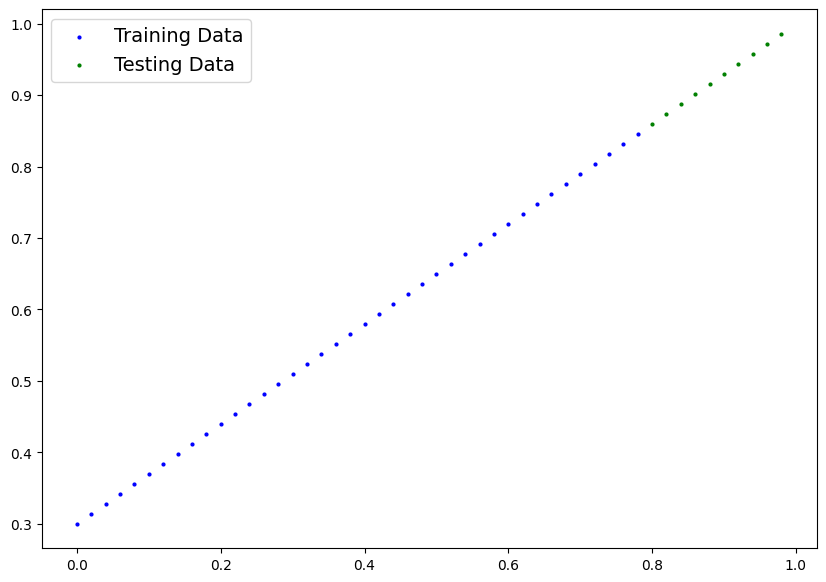

In [ ]:
def plotPredictions(trainData = XTrain,
                    trainLabels = yTrain,
                    testData = XTest,
                    testLabels = yTest,
                    predictions = None):

  plt.figure(figsize=(10, 7))
  plt.scatter(trainData, trainLabels, c = "b", s = 4, label = "Training Data")
  plt.scatter(testData, testLabels, c = "g", s = 4, label = "Testing Data")

  if predictions is not None:
    plt.scatter(testData, predictions, c = "r", s = 4, label = "Predictions")

  plt.legend(prop={"size": 14});

# =====================================================

plotPredictions();

In [ ]:
# Model building

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.weight = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

  # Forward defines that computation will take place on the data passed to the module
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias

In [ ]:
torch.manual_seed(42)

model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

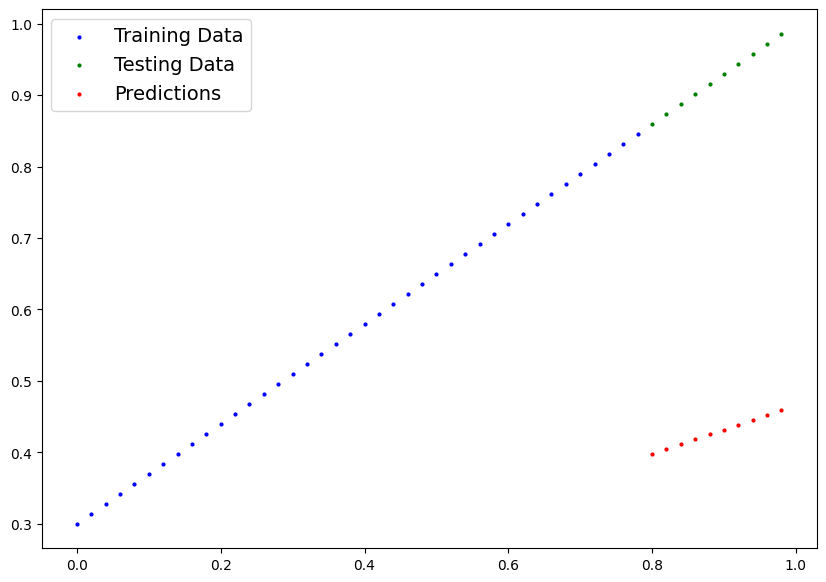

In [ ]:
# Making preditions

with torch.inference_mode():
  yPred = model0(XTest)

plotPredictions(predictions=yPred)

In [ ]:
# Training the model

lossFn = nn.L1Loss()  # MAE
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.01)

# Training loop
epochs = 100

trainLossVals = []
testLossVals = []
epochCount = []

for epoch in range(epochs):
  model0.train()  # Put model in traininf mode
  yPred = model0(XTrain)
  loss = lossFn(yPred, yTrain)  # Calculate loss function
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model0.eval()  # Put model in evaluation mode

  with torch.inference_mode():
    testPred = model0(XTest)
    testLoss = lossFn(testPred, yTest.type(torch.float))

    if epoch % 10 == 0:
      epochCount.append(epoch)
      trainLossVals.append(loss.detach().numpy())
      testLossVals.append(testLoss.detach().numpy())

      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {testLoss}")

Epoch: 0 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 10 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 20 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 30 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 40 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 50 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 60 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 70 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 80 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112
Epoch: 90 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112


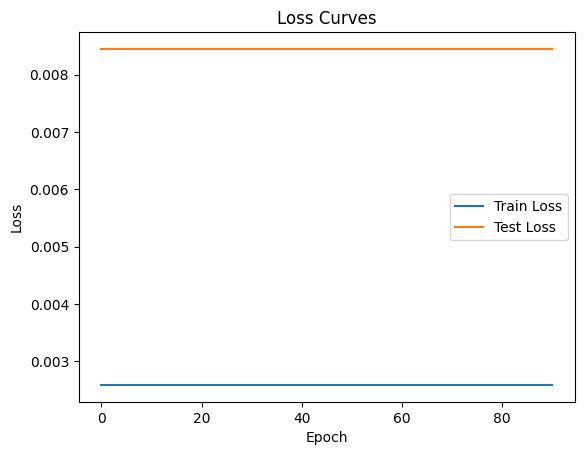

In [ ]:
# Plotting loss curves

plt.plot(epochCount, trainLossVals, label="Train Loss")
plt.plot(epochCount, testLossVals, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
model0.state_dict()

OrderedDict([('weight', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [ ]:
model0.eval()

with torch.inference_mode():
  yPred = model0(XTest)

yPred

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [ ]:
yPred - yTest

tensor([[-0.0046],
        [-0.0047],
        [-0.0048],
        [-0.0049],
        [-0.0050],
        [-0.0051],
        [-0.0052],
        [-0.0053],
        [-0.0054],
        [-0.0055]])

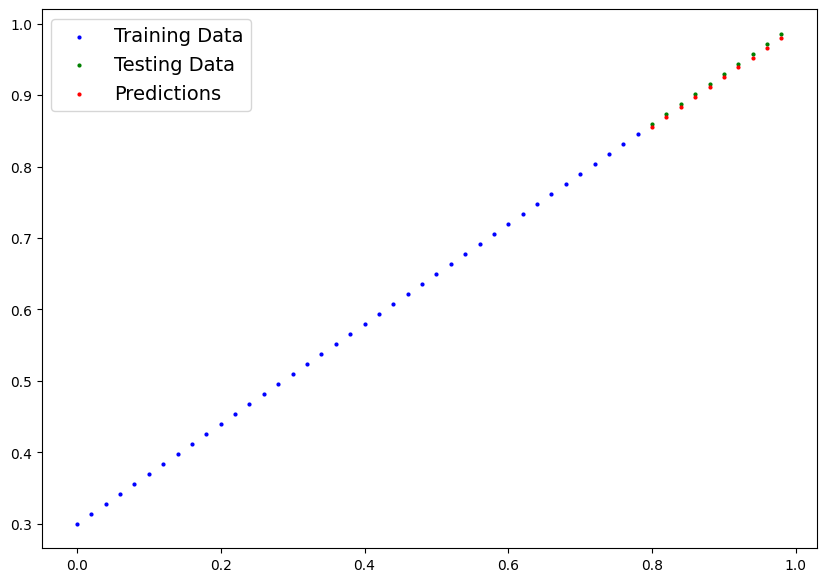

In [ ]:
plotPredictions(predictions=yPred)

In [ ]:
# Saving model

from pathlib import Path

# Creating model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Creating save path
MODEL_NAME = "LinearRegressorModel_1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Saving
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/LinearRegressorModel_1.pth


In [ ]:
!ls -l models/LinearRegressorModel_1.pth

-rw-r--r-- 1 root root 1187 Jun 27 05:12 models/LinearRegressorModel_1.pth


In [ ]:
# Loading saved model's state_dict()

loadedModel0 = LinearRegressionModel()
loadedModel0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the model in evaluation mode
loadedModel0.eval()

with torch.inference_mode():
  loadedModelPred = loadedModel0(XTest)

In [ ]:
yPred == loadedModelPred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])